In [1]:
import sys
import pandas as pd
import numpy as np
import itertools as it 
import matplotlib.pyplot as plt
from scipy.special import comb

sys.path.append('../')
sys.path.append('/rumi/shams/abe/Projects/ipage-down/')

from util import *
import ipage_down as ipd

Here, I aim to do _hyper-geometric test_ on enriched genesets (iPAGE results) in CRISPR screening experiment (Rho scores) to test hyper/hypo methylation enrichment. 

### Load data

Load `hl60` CRISPRi-screen data

In [2]:
data = load_data(screens=True)

In [3]:
data['hl60'].keys()

dict_keys(['exp1_DAC_rho', 'exp1_DAC_gamma', 'exp2_DAC_rho', 'exp2_DAC_gamma', 'exp2_GSK_rho', 'exp2_GSK_gamma'])

Load iPAGE results into python - using my [ipage-down](https://github.com/abearab/ipage-down) python script 

In [4]:
data['hl60']['exp1_DAC_rho_page'] = ipd.make_ipage_run_dict('../CRISPRi-screen/hl60_exp1_DAC_rho_delta_phenotype/')
data['hl60']['exp2_DAC_rho_page'] = ipd.make_ipage_run_dict('../CRISPRi-screen/hl60_exp2_DAC_rho_delta_phenotype/')

In [5]:
# https://gseapy.readthedocs.io/en/latest/gseapy_tutorial.html

### Run the hypergeom test





For this matter, we have:

    ○ N = # of all genes 
    ○ n/A = # of metylated genes OR enriched pathway's genes 
    ○ x = # of genes in n and A overlap 

https://github.com/JohnDeJesus22/DataScienceMathFunctions/blob/master/hypergeometricfunctions.py#L38

In [54]:
def hypergeom_pmf(N, A, n, x):
    '''
    Probability Mass Function for Hypergeometric Distribution
    :param N: population size
    :param A: total number of desired items in N
    :param n: number of draws made from N
    :param x: number of desired items in our draw of n items
    :returns: PMF computed at x
    '''
    Achoosex = comb(A,x)
    NAchoosenx = comb(N-A, n-x)
    Nchoosen = comb(N,n)
    
    return (Achoosex)*NAchoosenx/Nchoosen
    
    
def hypergeom_plot(N, A, n):
    '''
    Visualization of Hypergeometric Distribution for given parameters
    '''
    x = np.arange(0, n+1)
    y = [hypergeom_pmf(N, A, n, x) for x in range(n+1)]
    plt.plot(x, y, 'bo')
    plt.vlines(x, 0, y, lw=2)
    plt.xlabel('# of desired items in our draw')
    plt.ylabel('Probablities')
    plt.title('Hypergeometric Distribution Plot')
    plt.show()


def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 


def hypergeom_pw(pw,hyper, hypo):
    '''
    Run Hypergeometric test for given pathway
    '''
    res = list()
    for mtyl in [hyper, hypo]:
        N = 20000
        A = len(mtyl)
        n = len(pw)
        x = len(intersection(mtyl, pw))
        res.append(hypergeom_pmf(N, A, n, x))
    return res 


# def run_hypergeom(page):
#     '''
#     Return Hypergeometric test for all pathways in a ipage run 
#     '''
#     hyper, hypo = [set(list(mtyl.name)) for mtyl in two_sided_mtyl()]
    
#     pvs = [page[pw_clust]['pvmatrix'] for pw_clust in page]
#     top_pws = [[pvs[1].index[pvs[1].iloc[:,0] > 2].to_list(), pvs[1].index[pvs[1].iloc[:,10] > 2].to_list(),pw_clust] for pvmatrix, pw_clust in zip(pvs,page)]

#     up = list(it.chain(*[pws[0] for pws in top_pws]))
#     dn = list(it.chain(*[pws[1] for pws in top_pws]))
    
#     results = [
#         [pw,hypergeom_pw(page[gs_clust]['annotations'][pw]['genes'],hyper, hypo)]
#         for gs_clust in page for pw in page[gs_clust]['annotations']
#     ]
#     out = pd.DataFrame([r[1] for r in results],columns=['hyper', 'hypo'],index=[r[0] for r in results]).dropna()
    
#     return out 


def run_hypergeom(page):
    '''
    Return Hypergeometric test for all pathways in a ipage run 
    '''
    hyper, hypo = [set(list(mtyl.name)) for mtyl in two_sided_mtyl()]

    pvs = [page[pw_clust]['pvmatrix'] for pw_clust in page]


    res_up = [
        [pw,hypergeom_pw(page[pw_clust]['annotations'][pw]['genes'],hyper, hypo)]
        for pv, pw_clust in zip(pvs,page)
        for pw in pv.index[pv.iloc[:,10] > 2].to_list() 
        if pw in page[pw_clust]['annotations'].keys()
    ]

    res_dn = [
        [pw,hypergeom_pw(page[pw_clust]['annotations'][pw]['genes'],hyper, hypo)]

        for pv, pw_clust in zip(pvs,page)
        for pw in pv.index[pv.iloc[:,0] > 2].to_list() 
        if pw in page[pw_clust]['annotations'].keys()
    ]

    dfs = []
    for res in [res_up, res_dn]:
        dfs.append(pd.DataFrame([r[1] for r in res],columns=['hyper', 'hypo'],index=[r[0] for r in res]).dropna())
    
    up, dn = dfs
    
    return up, dn

In [24]:
page1 = data['hl60']['exp1_DAC_rho_page']
pvs = [page1[pw_clust]['pvmatrix'] for pw_clust in page1]
top_pws = [[pv.index[pv.iloc[:,0] >= 2].to_list(), pv.index[pv.iloc[:,10] >= 2].to_list(),pw_clust] for pv, pw_clust in zip(pvs,page1)]


In [55]:
run_hypergeom(page1)

/rumi/shams/abe/anaconda3/envs/deseq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/rumi/shams/abe/anaconda3/envs/deseq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


(                                                       hyper      hypo
 GO_TRANSLATIONAL_TERMINATION                        0.091582  0.071555
 GO_ATPASE_COMPLEX                                   0.073389  0.007019
 GO_TRNA_WOBBLE_URIDINE_MODIFICATION                 0.267145  0.377155
 GO_THIOESTER_BIOSYNTHETIC_PROCESS                   0.180967  0.204559
 GO_LIGASE_ACTIVITY_FORMING_CARBON_OXYGEN_BONDS      0.223923  0.204795
 GO_DIOXYGENASE_ACTIVITY                             0.095302  0.050590
 GO_POSITIVE_REGULATION_OF_DNA_BIOSYNTHETIC_PROCESS  0.015987  0.201734
 KCCGNSWTTT_UNKNOWN                                  0.019777  0.000001
 MIR4772_5P                                          0.196841  0.184311
 REACTOME_MITOCHONDRIAL_TRANSLATION                  0.140839  0.143357
 BURTON_ADIPOGENESIS_3                               0.089293  0.172756
 KEGG_AMINOACYL_TRNA_BIOSYNTHESIS                    0.223923  0.204795
 PID_CXCR3_PATHWAY                                   0.087149  0

In [56]:
res1 = [res.sort_values(['hyper','hypo']) for res in run_hypergeom(data['hl60']['exp1_DAC_rho_page'])]
res2 = [res.sort_values(['hyper','hypo']) for res in run_hypergeom(data['hl60']['exp2_DAC_rho_page'])]

# pws = list(set(res1.index) & set(res1.index))
# res1= res1.loc[pws,]
# res2= res2.loc[pws,]

/rumi/shams/abe/anaconda3/envs/deseq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/rumi/shams/abe/anaconda3/envs/deseq/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


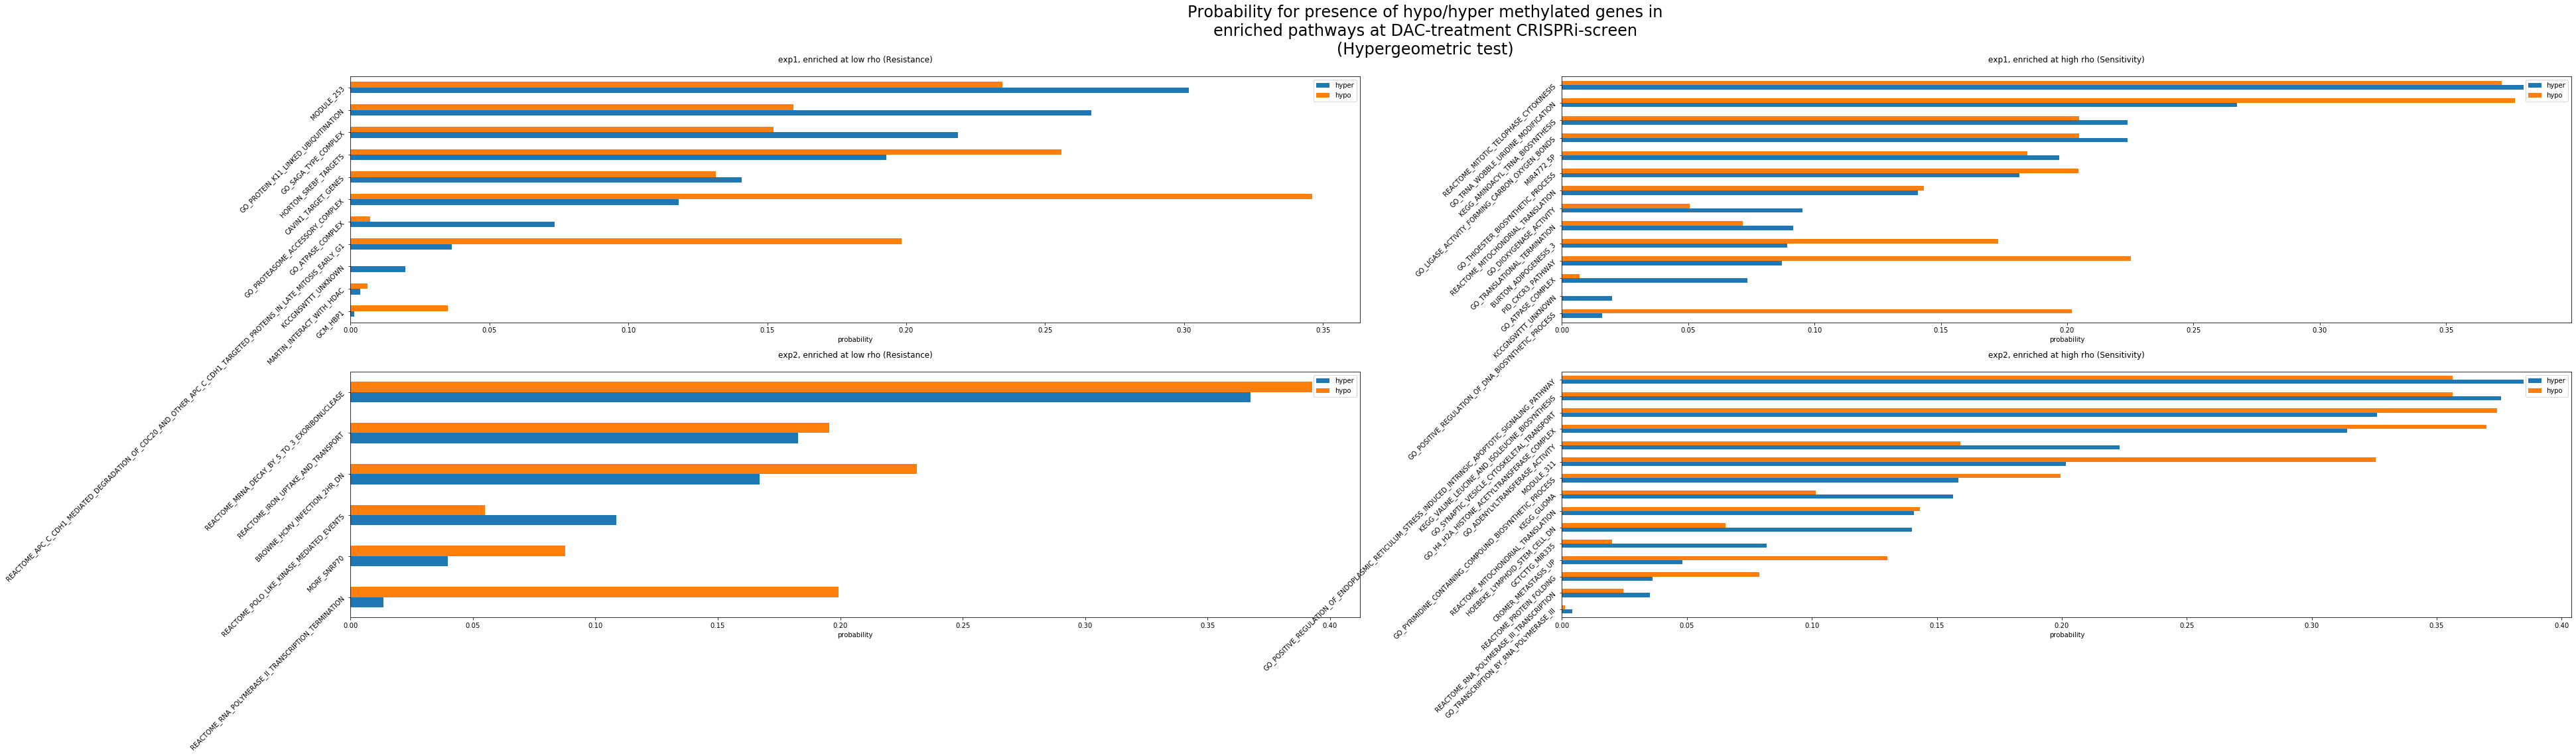

In [103]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(60,15))

plot1 = res1[0].plot.barh(title='exp1, enriched at high rho (Sensitivity)\n',ax=axes[0,1])
plot1.set_xlabel('probability')
plot2 = res2[0].plot.barh(title='exp2, enriched at high rho (Sensitivity)\n',ax=axes[1,1])
plot2.set_xlabel('probability')

plot3 = res1[1].plot.barh(title='exp1, enriched at low rho (Resistance)\n',ax=axes[0,0])
plot3.set_xlabel('probability')

plot4 = res2[1].plot.barh(title='exp2, enriched at low rho (Resistance)\n',ax=axes[1,0])
plot4.set_xlabel('probability')


plt.suptitle('Probability for presence of hypo/hyper methylated genes in\nenriched pathways at DAC-treatment CRISPRi-screen\n(Hypergeometric test)\n\n',size=24)
for ax in fig.axes:
    plt.sca(ax)
    plt.yticks(rotation=45)
    
plt.show()

In [104]:
fig.savefig("hyper-geometric-test.pdf", bbox_inches='tight')